# Square pulse FM Radio

### Specifications
* Frequency range: DC-108 MHz 
* Board: [Cora-Z7-07S board](https://store.digilentinc.com/cora-z7-zynq-7000-single-core-and-dual-core-options-for-arm-fpga-soc-development/).
* Radio output pin: ck_io7
* Status: led0_g (on/off)
 

### System Architecture
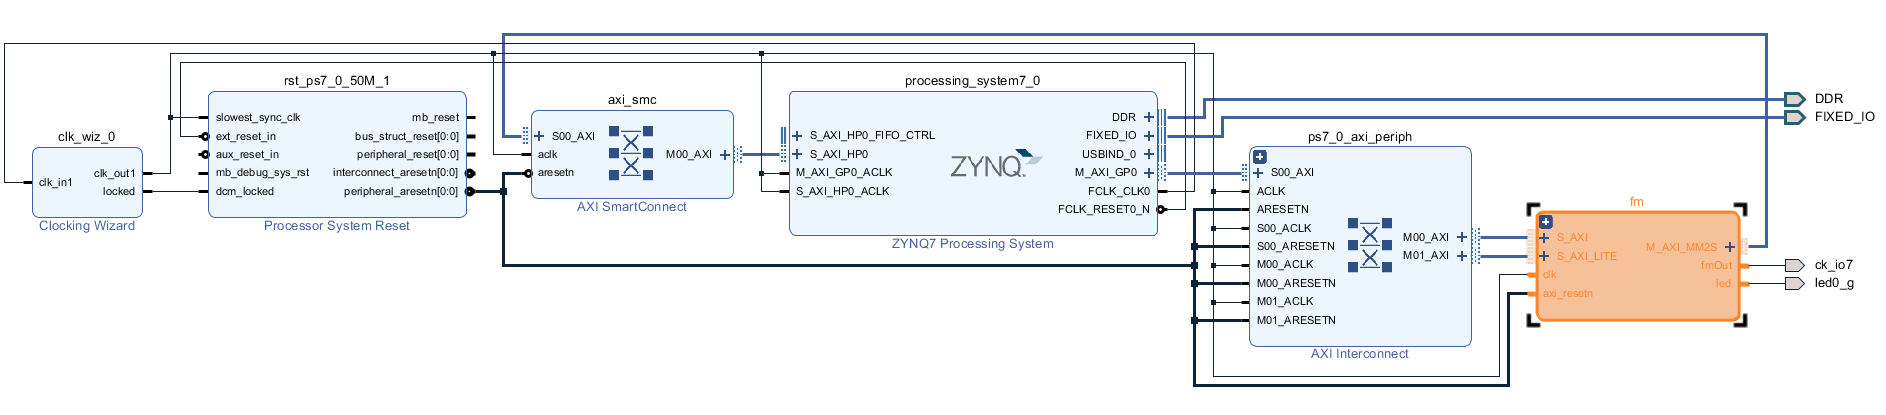

### FM Subarchitecture
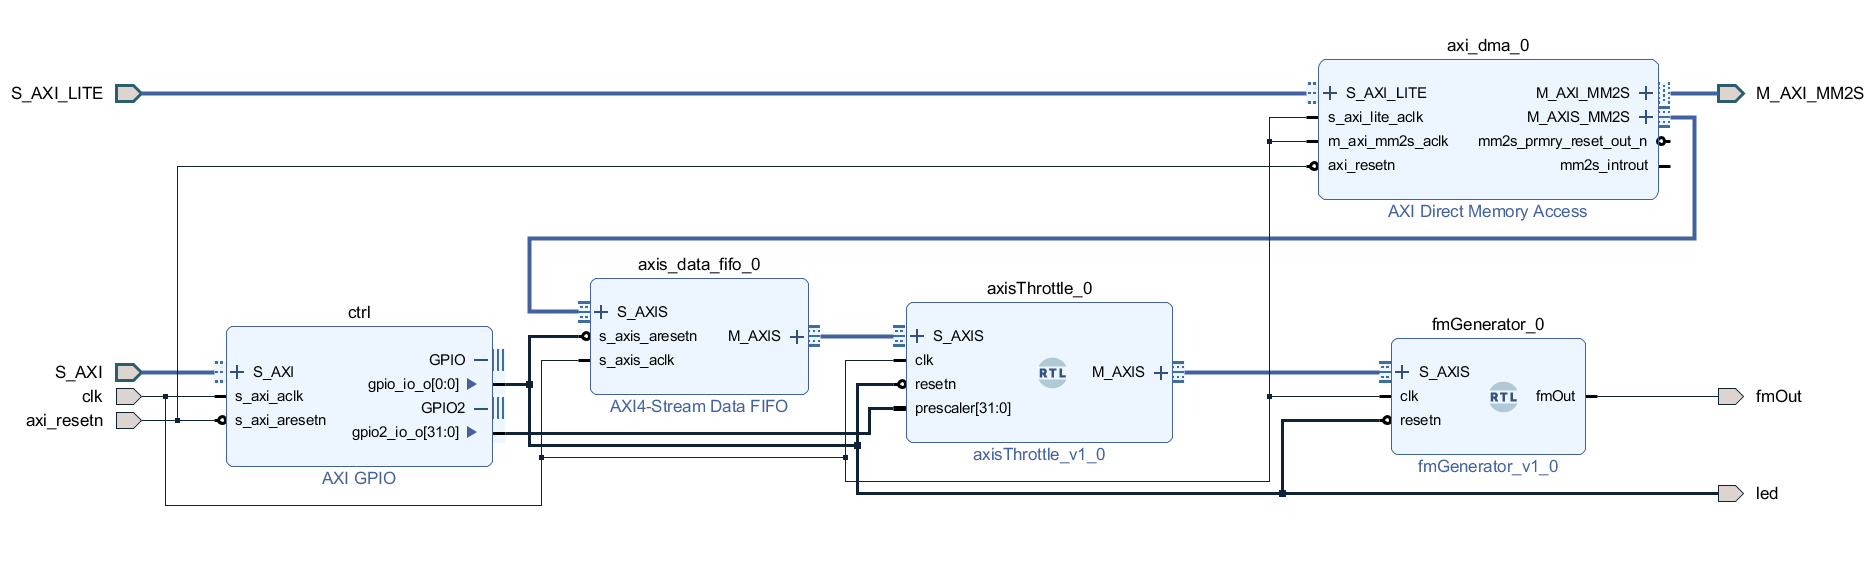

In [ ]:
import numpy as np
import time
from scipy.io import wavfile
from pynq import Overlay,allocate
from scipy.io import wavfile

ol=Overlay("fmRadio.bit")

def setResetn(val):
    mask=0xffffffff
    resetn=0
    ol.fm.ctrl.channel1.write(val,mask)
    return

def setAxisThrottle(clkFreq,audioSampligFreq):
    mask=0xffffffff
    resetn=1
    prescaler=int(clkFreq/audioSampligFreq)-1
    ol.fm.ctrl.channel2.write(prescaler,mask)
    return

In [ ]:
#PARAMETERS VIVADO DESIGN
clkFreq=108e6
bufferSize=16384

In [ ]:
#PARAMETERS FM
baseband=94e6  #Baseband frequnecy (Hz)
fmMax=75e3     #Max. frequency modulation (Hz)

In [ ]:
#LOAD AUDIO
audioSampligFreq, data = wavfile.read('./songs/mambo_no_5-lou_bega.wav')
print(audioSampligFreq,data.dtype,len(data))

In [ ]:
dataFm=(baseband+fmMax*data/2**16)/(2*clkFreq)*2**32
dataFm=np.array(dataFm,dtype="uint32")

setResetn(0) #RESET/STOP
setAxisThrottle(clkFreq,audioSampligFreq)
setResetn(1) #RUN


input_buffer = allocate(shape=(bufferSize,), dtype=np.uint32)
iMax=int(len(dataFm)/bufferSize)
remainder=len(dataFm)%bufferSize
t0=time.time()
for i in range(0,iMax):
    print("t=%.1fs"%(time.time()-t0))
    np.copyto(input_buffer,dataFm[int(i*bufferSize):int((i+1)*bufferSize)])  
    ol.fm.axi_dma_0.sendchannel.transfer(input_buffer)
    ol.fm.axi_dma_0.sendchannel.wait()
    
np.copyto(input_buffer,np.array(np.append(dataFm[-remainder:],np.zeros(bufferSize-remainder)),dtype="uint32")) 
ol.fm.axi_dma_0.sendchannel.transfer(input_buffer)
ol.fm.axi_dma_0.sendchannel.wait()   
time.sleep(1)
setResetn(0) #RESET/STOP